In [390]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.layers import Embedding, Flatten, Dot
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import radians, sin, cos, sqrt, atan2

In [391]:
user = pd.read_csv('./data/user.csv')
destination = pd.read_csv('./data/destinasi-wisata-indonesia.csv')
bali =  pd.read_csv('./data/Dataset - tourismBali.csv')

In [392]:
user.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20


In [393]:
bali.head()

,Place_Id,Place_Name,Description,Weekend Holiday Price,Weekday Price,Category,City,Rating,Alamat,Coordinate,Lat,Long,Gambar
0,1,Agrowisata Satria,Agrowisata Satria menawarkan 'rasa' Bali pada ...,50000,50000,Agrowisata,Gianyar,3.0,"Manukaya, Kec. Tampaksiring, Kabupaten Gianya...","-8.402228546131536, 115.32296693687739",-8.402229,115.322967,V
1,2,Agung Bali,Dapatkan berbagai produk oleh-oleh khas Bali b...,0,0,Belanja,Badung,4.0,"Jln. Dewi Sri No.18XX, Kuta, Badung, Bali","-8.700234336021559, 115.176534407375",-8.700234,115.176534,V
2,3,Wisata Air Panas Toya Bungkah,Pemandian air panas di dekat gunung Batur (Pem...,70000,70000,Alam,Bangli,4.0,"Batur Tengah, Kec. Kintamani, Kabupaten Bangli...","-8.251298580809106, 115.39981444195475",-8.251299,115.399814,V
3,4,Air Terjun Aling-Aling,Keberadaan air terjun ini semakin mempercantik...,20000,20000,Alam,Buleleng,4.5,"Jl. Raya Desa Sambangan, Banjar, Sambangan, Ke...","-8.173073590748519, 115.10513024047802",-8.173074,115.105130,V
4,5,Air Terjun Tegenungan,Bosan dengan wisata alam pantai dan ingin meni...,20000,20000,Alam,Gianyar,4.0,"Jl. Ir. Sutami, Kemenuh, Kec. Sukawati, Kabupa...","-8.575191460385602, 115.28870189592831",-8.575191,115.288702,V


In [394]:
bali[['Weekday Price', 'Weekend Holiday Price']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Weekday Price          75 non-null     int64
 1   Weekend Holiday Price  75 non-null     int64
dtypes: int64(2)
memory usage: 1.3 KB


In [395]:
mean = (bali['Weekday Price'].values + bali['Weekend Holiday Price'].values) / 2

In [396]:
mean

array([ 50000.,      0.,  70000.,  20000.,  20000.,  15000., 300000.,
       102500.,  20000., 500000.,      0.,  32500.,  50000.,      0.,
        15000.,  30000.,  10000.,  10000.,      0.,      0.,      0.,
        95000.,  30000.,  25000.,  15000.,  10000.,      0.,  40000.,
            0.,      0.,  25000.,      0.,  60000.,  25000.,  25000.,
        10000.,  10000.,      0.,      0.,  10000.,  10000.,      0.,
            0.,   5000.,      0.,   8000.,      0.,   5000.,   8000.,
            0.,      0.,  10000.,      0.,      0.,      0.,      0.,
        30000.,  30000.,  10000.,  50000.,  15000.,      0.,  15000.,
        15000.,  30000.,  50000.,      0.,      0., 100000., 150000.,
        10000.,  25000., 289000.,  10000.,      0.])

In [397]:
bali['Price'] = mean

In [398]:
bali.columns

Index(['Place_Id', 'Place_Name', 'Description', 'Weekend Holiday Price',
       'Weekday Price', 'Category', 'City', 'Rating', 'Alamat', 'Coordinate',
       'Lat', 'Long', 'Gambar', 'Price'],
      dtype='object')

In [399]:
destination.columns

Index(['Place_Id', 'Place_Name', 'Description', 'Category', 'City', 'Price',
       'Rating', 'Time_Minutes', 'Coordinate', 'Lat', 'Long', 'Column1', '_1',
       'Rating_Count'],
      dtype='object')

In [400]:
bali = bali[['Place_Id', 'Place_Name', 'Description', 'Category', 'City', 'Price', 'Rating', 'Coordinate', 'Lat', 'Long']]

In [401]:
bali['City'] = 'Bali'

In [402]:
destination = pd.concat([destination, bali], ignore_index=True)

In [403]:
destination.shape

(512, 14)

In [404]:
destination.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Column1,_1,Rating_Count
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000.0,46.0,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-61753924.0,1.068272e+09,NaN,1.0,18.0
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0.0,46.0,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-61376448.0,1.068171e+09,NaN,2.0,25.0
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000.0,46.0,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-61253124.0,1.068335e+09,NaN,3.0,19.0
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000.0,45.0,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-63024459.0,1.068952e+09,NaN,4.0,21.0
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000.0,45.0,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-612419.0,1.068391e+08,NaN,5.0,24.0


In [405]:
destination['City'].value_counts()

City
Yogyakarta    126
Bandung       124
Jakarta        84
Bali           75
Semarang       57
Surabaya       46
Name: count, dtype: int64

In [406]:
destination['Category'].unique()

array(['Budaya', 'Taman Hiburan', 'Cagar Alam', 'Bahari',
       'Pusat Perbelanjaan', 'Tempat Ibadah', 'Agrowisata', 'Belanja',
       'Alam', 'Rekreasi', 'Religius', 'Pantai'], dtype=object)

In [407]:
destination['Category'] = destination['Category'].replace('Pantai', 'Bahari')

In [408]:
destination['Category'].unique()

array(['Budaya', 'Taman Hiburan', 'Cagar Alam', 'Bahari',
       'Pusat Perbelanjaan', 'Tempat Ibadah', 'Agrowisata', 'Belanja',
       'Alam', 'Rekreasi', 'Religius'], dtype=object)

In [409]:
destination[destination['Category'] == 'Bahari' ].sample(7)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Column1,_1,Rating_Count
181,182,Hutan Mangrove Kulon Progo,Di sini ada kawasan wisata Hutan Mangrove Kulo...,Bahari,Yogyakarta,5000.0,41.0,120.0,"{'lat': -7.8933459, 'lng': 110.0198257}",-7.893346e+07,1.100198e+09,NaN,182.0,17.0
208,209,Pantai Sanglen,Pantai Sanglen. Lokasinya berada di Desa Kemad...,Bahari,Yogyakarta,10000.0,45.0,NaN,"{'lat': -8.1367456, 'lng': 110.5716362}",-8.136746e+07,1.105716e+09,NaN,209.0,14.0
198,199,Pantai Sedahan,Pantai Sedahan ini memiliki garis pantai yang ...,Bahari,Yogyakarta,5000.0,45.0,NaN,"{'lat': -8.1978943, 'lng': 110.7208535}",-8.197894e+07,1.107209e+09,NaN,199.0,19.0
475,39,Pantai Canggu,Keunikan Pantai Canggu adalah hamparan sawah d...,Bahari,Bali,0.0,4.0,NaN,"-8.660786688817117, 115.13213191019071",-8.660787e+00,1.151321e+02,NaN,NaN,NaN
209,210,Pantai Congot,"Selain Pantai Glagah dan Pantai Trisik, ternya...",Bahari,Yogyakarta,3000.0,43.0,NaN,"{'lat': -7.907542500000001, 'lng': 110.0535658}",-7.907542e+07,1.100536e+09,NaN,210.0,23.0
473,37,Pantai Atuh,Pantai Atuh merupakan pantai kecil yang memili...,Bahari,Bali,10000.0,4.5,NaN,"-8.771205553608526, 115.62224770937999",-8.771206e+00,1.156222e+02,NaN,NaN,NaN
189,190,Pantai Samas,"Pantai Samas (bahasa Jawa: ꦥꦱꦶꦱꦶꦂ​ꦱꦩꦱ꧀, transl...",Bahari,Yogyakarta,4000.0,4.0,45.0,"{'lat': -8.0045535, 'lng': 110.2703756}",-8.004554e+07,1.102704e+09,NaN,190.0,25.0


In [410]:
destination.isnull().sum()

Place_Id          0
Place_Name        0
Description       0
Category          0
City              0
Price             0
Rating            0
Time_Minutes    307
Coordinate        0
Lat               0
Long              0
Column1         512
_1               75
Rating_Count     75
dtype: int64

In [411]:
destination.drop(columns=['Place_Id','Time_Minutes', 'Column1', '_1', 'Rating_Count'], inplace=True)

In [412]:
destination.columns

Index(['Place_Name', 'Description', 'Category', 'City', 'Price', 'Rating',
       'Coordinate', 'Lat', 'Long'],
      dtype='object')

In [413]:
destination = destination.rename(columns={'Place_Name':'place_name',
                                          'Description':'description',
                                          'Category':'category',
                                          'City':'city',
                                          'Price':'price',
                                          'Rating':'rating_avg',
                                          'Lat': 'latitude', 
                                          'Long': 'longitude',
                                          'Coordinate':'coordinate'})

In [414]:
destination.duplicated().sum()

0

In [415]:
destination.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   place_name   512 non-null    object 
 1   description  512 non-null    object 
 2   category     512 non-null    object 
 3   city         512 non-null    object 
 4   price        512 non-null    float64
 5   rating_avg   512 non-null    float64
 6   coordinate   512 non-null    object 
 7   latitude     512 non-null    float64
 8   longitude    512 non-null    float64
dtypes: float64(4), object(5)
memory usage: 36.1+ KB


##REKOMENDASI BY KATEGORI WISATA

### PREPROCESSING
di encode + cari kesamaan pake cosine similarity

In [416]:
oneHotCategory = OneHotEncoder(sparse=False)

In [417]:
categoryEncoded = oneHotCategory.fit_transform(destination[['category']])

c:\Users\Akmal Fauzan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [418]:
categoryEncoded = pd.DataFrame(categoryEncoded, columns=oneHotCategory.get_feature_names_out(['category']))

In [419]:
categoryEncoded

,category_Agrowisata,category_Alam,category_Bahari,category_Belanja,category_Budaya,category_Cagar Alam,category_Pusat Perbelanjaan,category_Rekreasi,category_Religius,category_Taman Hiburan,category_Tempat Ibadah
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
507,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
510,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [420]:
cosineSim = cosine_similarity(categoryEncoded)

In [421]:
cosineSim = pd.DataFrame(cosine_similarity(categoryEncoded), index=destination.index, columns=destination.index)

In [422]:
cosineSim

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0


### Content-Based

In [423]:
def getRecommendationsByCategory(selected_category, destination, cosineSim, top_n=5):
    # Cari indeks destinasi yang memiliki kategori sesuai dengan kategori yang dipilih
    category_indices = destination[destination['category'] == selected_category].index

    if category_indices.empty:
        print("Kategori yang dipilih tidak ditemukan dalam data destinasi.")
        return []

    recommendations = []

    for idx in category_indices:
        similarity_scores = cosineSim.loc[idx]
        sorted_scores = similarity_scores.sort_values(ascending=False).iloc[1:]
        
        recommended_indices = sorted_scores.head(top_n).index
        recommended_places = destination.loc[recommended_indices, ['place_name', 'category']]

        recommendations.extend(recommended_places.to_dict('records'))

    unique_recommendations = {rec['place_name']: rec['category'] for rec in recommendations}
    return list(unique_recommendations.items())

In [424]:
recommendations = getRecommendationsByCategory("Bahari", destination, cosineSim, top_n=5)
print("Rekomendasi Berdasarkan Kategori Wisata:")
for place, category in recommendations:
    print(f"{place} - Kategori: {category}")

Rekomendasi Berdasarkan Kategori Wisata:
Pantai Jimbaran - Kategori: Bahari
Pantai Krakal - Kategori: Bahari
Pantai Sepanjang - Kategori: Bahari
Pantai Goa Cemara - Kategori: Bahari
Hutan Mangrove Kulon Progo - Kategori: Bahari


### Rekomendasi Terdekat

In [425]:
destination['latitude'] = destination['latitude'].apply(lambda x: float(str(x).replace("'", "").replace("{", "").replace("}", "").split(':')[-1].strip()))
destination['longitude'] = destination['longitude'].apply(lambda x: float(str(x).replace("'", "").replace("{", "").replace("}", "").split(':')[-1].strip()))

In [426]:
destination

,place_name,description,category,city,price,rating_avg,coordinate,latitude,longitude
0,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000.0,46.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392e+07,1.068272e+09
1,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0.0,46.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645e+07,1.068171e+09
2,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000.0,46.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312e+07,1.068335e+09
3,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000.0,45.0,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446e+07,1.068952e+09
4,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000.0,45.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190e+05,1.068391e+08
...,...,...,...,...,...,...,...,...,...
507,Teras Sawah Tegalalang,"Uniknya Tegallalang Rice Terrace di Bali ini, ...",Agrowisata,Bali,10000.0,4.0,"-8.433891714602193, 115.27918179571854",-8.433892e+00,1.152792e+02
508,Tirta Gangga,Ada tiga hal utama yang ada di taman Tirta Gan...,Religius,Bali,25000.0,4.5,"-8.412071345387545, 115.58728116872855",-8.412071e+00,1.155873e+02
509,Waterbom Bali,Waterbom merupakan sebuah oase di jantung kawa...,Rekreasi,Bali,289000.0,4.5,"-8.72828817001415, 115.16934211106027",-8.728288e+00,1.151693e+02
510,Alas Harum Agro Tourism,Alas Harum Bali merupakan destinasi wisata yan...,Agrowisata,Bali,10000.0,4.0,"-8.43969896624251, 115.28060749756382",-8.439699e+00,1.152806e+02


In [427]:
destination[['place_name', 'latitude', 'longitude']].sample(5)

,place_name,latitude,longitude
478,Pantai Double Six,-8.697360e+00,1.151621e+02
405,Kebun Bibit Wonorejo,-7.312366e+07,1.127889e+09
440,Air Terjun Aling-Aling,-8.173074e+00,1.151051e+02
117,Museum Sonobudoyo Unit I,-7.802450e+07,1.103640e+09
107,Embung Tambakboyo,-7.756227e+06,1.104150e+09


In [428]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [429]:
def getTempatTerdekat(user_lat, user_long, data, top_n=5):
    data['distance_km'] = data.apply(lambda row: haversine(user_lat, user_long, row['latitude'], row['longitude']), axis=1)
    nearest_places = data.sort_values(by='distance_km').head(top_n)
    return nearest_places

In [452]:
user_lat, user_long = -7.802450e+07, 1.103640e+09

In [453]:
nearest_places = getTempatTerdekat(user_lat, user_long, destination)

In [454]:
nearest_places[['place_name', 'category', 'city', 'distance_km']]

,place_name,category,city,distance_km
436,Gereja Perawan Maria Tak Berdosa Surabaya,Tempat Ibadah,Surabaya,381.466329
213,Trans Studio Bandung,Taman Hiburan,Bandung,421.744835
354,Umbul Sidomukti,Cagar Alam,Semarang,431.730056
75,Taman Cattleya,Taman Hiburan,Jakarta,483.949566
74,SnowBay Waterpark,Taman Hiburan,Jakarta,543.701867


In [433]:
destination.to_csv('./data/destinasiWisata.csv', index=False)

### Collaborative Filtering

In [434]:
review = pd.read_csv('./data/review.csv')

In [435]:
dummy_data = {
    'user_id': np.random.randint(1, 1001, 10000),  
    'item_id': np.random.randint(1, 501, 10000),  
    'rating': np.random.randint(1, 6, 10000)     
}

review = pd.DataFrame(dummy_data)

In [436]:
review['user_id'] = review['user_id'].astype(int)
review['item_id'] = review['item_id'].astype(int)
review['rating'] = review['rating'].astype(int)

In [437]:
# jumlah pengguna dan item unik
n_users = review['user_id'].nunique()
n_items = review['item_id'].nunique()

In [438]:
user_input = tf.keras.layers.Input(shape=(1,))
item_input = tf.keras.layers.Input(shape=(1,))

In [439]:
user_embedding = Embedding(n_users + 1, 50)(user_input)  
item_embedding = Embedding(n_items + 1, 50)(item_input)

In [440]:
user_vec = Flatten()(user_embedding)
item_vec = Flatten()(item_embedding)
rating = Dot(axes=1)([user_vec, item_vec])

In [441]:
model = Model(inputs=[user_input, item_input], outputs=rating)
model.compile(optimizer='adam', loss='mse')

In [442]:
history = model.fit([review['user_id'], review['item_id']], review['rating'], epochs=50, batch_size=64)

Epoch 1/50


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10.8398
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.9999
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.8400
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.3550
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.0261
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9294
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7957
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0625
Epoch 9/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0953
Epoch 10/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6866
Epoch 11/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4063
Epoch 12/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2921
Epoch 13/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1809
Epoch 14/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0715
Epoch 15/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9

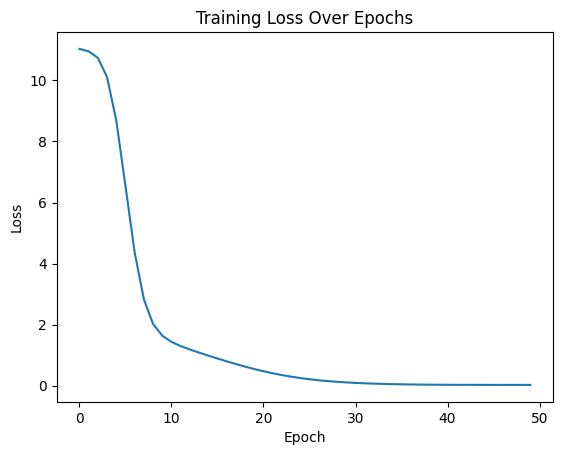

In [443]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

In [444]:
train, test = train_test_split(review, test_size=0.2)
history = model.fit([train['user_id'], train['item_id']], train['rating'], epochs=50, batch_size=64)
predictions = model.predict([test['user_id'], test['item_id']])

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0183  
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0203  
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0271
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0234
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0214  
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0228  
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0256
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0218
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0203 
Epoch 10/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0214
Epoch 11/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0236
Epoch 12/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0238
Epoch 13/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0271
Epoch 14/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0272
Epoch 15/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

In [445]:
mse = mean_squared_error(test['rating'], predictions)
print("Mean Squared Error (MSE) pada data uji:", mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE) pada data uji:", rmse)

Mean Squared Error (MSE) pada data uji: 0.04605115102006201
Root Mean Squared Error (RMSE) pada data uji: 0.21459531919420333


In [446]:
def recommend_items(user_id, model, n_recommendations=5):
    item_ids = np.array(review['item_id'].unique()) 
    user_ids = np.array([user_id] * len(item_ids)).reshape(-1, 1)  
    item_ids = item_ids.reshape(-1, 1)  
    
    # Prediksi rating untuk semua item yang belum di-review user
    predicted_ratings = model.predict([user_ids, item_ids]).flatten()  
    
    # Ambil item dengan rating prediksi tertinggi
    top_items = item_ids[np.argsort(predicted_ratings)[-n_recommendations:]].flatten()
    return top_items

In [447]:
# coba Rekomendasi untuk user_id 2
recommended_items = recommend_items(2, model)
print("Rekomendasi item untuk user_id 2:", recommended_items)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Rekomendasi item untuk user_id 2: [114   8 427  78 461]


In [448]:
review[review['user_id'] == 2]

,user_id,item_id,rating
969,2,369,4
1312,2,261,3
1908,2,68,1
2583,2,28,1
3504,2,427,5
5209,2,365,3
8177,2,235,4
8356,2,174,4
9608,2,78,5
